# M2177.004300 002 Deep Learning <br> Assignment #1 Part 1: Training Multi-Layer Perceptrons

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

The goal of this assignment is to progressively train deeper and more accurate models using PyTorch.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done problems, run the *CollectSubmission.sh* script with your **Student number** as input argument. <br>
This will produce a compressed file called *[Your student number].tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; 20\*\*-\*\*\*\*\*)

## Download datasets

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data' # Change me to store data elsewhere

if not os.path.exists(data_root):
    os.makedirs(data_root)

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./data\notMNIST_large.tar.gz
Found and verified ./data\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(0)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print(f'{root} already present - Skipping extraction of {filename}.')
    else:
        print(f'Extracting data for {root}. This may take a while. Please wait.')
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(f'Expected {num_classes} folders, one per class. Found {len(data_folders)} instead.')
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./data\notMNIST_large already present - Skipping extraction of ./data\notMNIST_large.tar.gz.
['./data\\notMNIST_large\\A', './data\\notMNIST_large\\B', './data\\notMNIST_large\\C', './data\\notMNIST_large\\D', './data\\notMNIST_large\\E', './data\\notMNIST_large\\F', './data\\notMNIST_large\\G', './data\\notMNIST_large\\H', './data\\notMNIST_large\\I', './data\\notMNIST_large\\J']
./data\notMNIST_small already present - Skipping extraction of ./data\notMNIST_small.tar.gz.
['./data\\notMNIST_small\\A', './data\\notMNIST_small\\B', './data\\notMNIST_small\\C', './data\\notMNIST_small\\D', './data\\notMNIST_small\\E', './data\\notMNIST_small\\F', './data\\notMNIST_small\\G', './data\\notMNIST_small\\H', './data\\notMNIST_small\\I', './data\\notMNIST_small\\J']



Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded.

---

In [4]:
from IPython.display import Image, display

display(Image(filename= os.path.abspath('data/notMNIST_large/A/ZXVyb2Z1cmVuY2UgYm9sZGl0YWxpYy50dGY=.png')))

## Load datasets

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values.

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:            
            image_data = (plt.imread(image_file, 0).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception(f'Unexpected image shape: {str(image_data.shape)}')
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception(f'Many fewer images than expected: {num_images} < {min_num_images}')

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print(f'{set_filename} already present - Skipping pickling.')
        else:
            print(f'Pickling {set_filename}.')
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./data\notMNIST_large\A.pickle already present - Skipping pickling.
./data\notMNIST_large\B.pickle already present - Skipping pickling.
./data\notMNIST_large\C.pickle already present - Skipping pickling.
./data\notMNIST_large\D.pickle already present - Skipping pickling.
./data\notMNIST_large\E.pickle already present - Skipping pickling.
./data\notMNIST_large\F.pickle already present - Skipping pickling.
./data\notMNIST_large\G.pickle already present - Skipping pickling.
./data\notMNIST_large\H.pickle already present - Skipping pickling.
./data\notMNIST_large\I.pickle already present - Skipping pickling.
./data\notMNIST_large\J.pickle already present - Skipping pickling.
./data\notMNIST_small\A.pickle already present - Skipping pickling.
./data\notMNIST_small\B.pickle already present - Skipping pickling.
./data\notMNIST_small\C.pickle already present - Skipping pickling.
./data\notMNIST_small\D.pickle already present - Skipping pickling.
./data\notMNIST_small\E.pickle already present -


Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

---

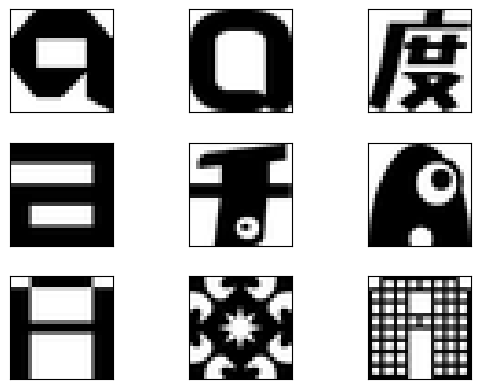

In [6]:
file = open(train_datasets[0], "rb")
images = pickle.load(file)
file.close()

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
        # Plot image.
    ax.imshow(images[i].reshape([28, 28]), cmap='binary')               
        
        # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
plt.show()

Another check: we expect the data to be balanced across classes. Verify that if the number of samples across classes are balanced.

---

In [7]:
for data in train_datasets:
    file = open(data, "rb")
    images = pickle.load(file)
    print('file : ', file, 'number of samples : ', images.shape[0])
    file.close()

file :  <_io.BufferedReader name='./data\\notMNIST_large\\A.pickle'> number of samples :  52909
file :  <_io.BufferedReader name='./data\\notMNIST_large\\B.pickle'> number of samples :  52911
file :  <_io.BufferedReader name='./data\\notMNIST_large\\C.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\D.pickle'> number of samples :  52911
file :  <_io.BufferedReader name='./data\\notMNIST_large\\E.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\F.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\G.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\H.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\I.pickle'> number of samples :  52912
file :  <_io.BufferedReader name='./data\\notMNIST_large\\J.pickle'> number of samples :  52911


## Generate train, test, validation sets

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels

            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Convince yourself that the data is still good after shuffling! Display one of the images and see if it's not distorted.

---

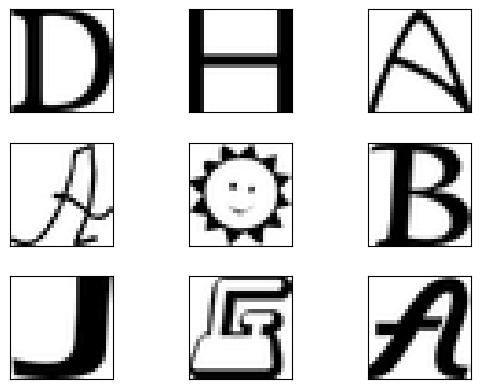

In [10]:
images = train_dataset

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
        # Plot image.
    ax.imshow(images[i].reshape([28, 28]), cmap='binary')               
        
        # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
plt.show()

Finally, let's save the data for later reuse:

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800438


## Load datasets

First reload the data we generated.

In [13]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- unnormalize data
- data as a flat matrix

In [14]:
image_size = 28
num_labels = 10

def reformat(dataset):
    dataset = dataset * 255.0 + 255.0/2
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    return dataset

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000,)
Validation set (10000, 784) (10000,)
Test set (10000, 784) (10000,)


## Train a Multi-Layer Perceptron (MLP)

Now, we are going to train a **multi-layer perceptron** using stochastic gradient descent (SGD).

In [15]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import torch.optim as optim

### First, define NotMNIST dataset class.  
- dataset class inherits torch.utils.data.Dataset class  
- dataset class should define \_\_len\_\_() and \_\_getitem\_\_()

In [16]:
class NotMNIST(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_idx = self.data[idx]
        label_idx = self.label[idx]
        return data_idx, label_idx

    
notmnist_train = NotMNIST(train_dataset, train_labels)
notmnist_valid = NotMNIST(valid_dataset, valid_labels)
notmnist_test = NotMNIST(test_dataset, test_labels)

print('Training set size: ', len(notmnist_train))
print('Validation set size: ', len(notmnist_valid))
print('Test set size: ', len(notmnist_test))

Training set size:  200000
Validation set size:  10000
Test set size:  10000


### Then make dataloader using NotMNIST dataset objects  
Note that torch.utils.data.DataLoader is a subclass of Iterable, which means it can be used with 'for' statement (for more detailed explanation of Iterable, refer to https://shoark7.github.io/programming/python/iterable-iterator-generator-in-python)  

In [17]:
batch_size = 64

train_loader = DataLoader(dataset=notmnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=notmnist_valid, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=notmnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

from collections.abc import Iterable
print(issubclass(DataLoader, Iterable))
print()

inputs, labels = next(iter(train_loader))
print(f'Type of inputs: {type(inputs)}\tshape: {inputs.shape}')
print(f'Type of labels: {type(labels)}\tshape: {labels.shape}')
print()

print('Train loader size: ', len(train_loader)) # same as len(dataset) // batch_size
print('Valid loader size: ', len(valid_loader))
print('Test loader size: ', len(test_loader))

True

Type of inputs: <class 'torch.Tensor'>	shape: torch.Size([64, 784])
Type of labels: <class 'torch.Tensor'>	shape: torch.Size([64])

Train loader size:  3125
Valid loader size:  157
Test loader size:  157


### Define Naive Linear model
- model should inherit nn.Module
- implement feed forward by overriding **forward** method of nn.Module

In [18]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class NaiveLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(NaiveLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        torch.nn.init.uniform_(self.weight, -1.0, 1.0)
        torch.nn.init.zeros_(self.bias)
    
    def forward(self, x):
        return torch.matmul(x, self.weight) + self.bias

In [19]:
class Model(nn.Module):
    
    def __init__(self, in_features, nn_hidden, num_labels):
        super(Model, self).__init__()
        self.fc1 = NaiveLinear(in_features, nn_hidden)
        self.fc2 = NaiveLinear(nn_hidden, num_labels)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
nn_hidden = 1024

model = Model(image_size*image_size, nn_hidden, num_labels)

# move model to GPU
if torch.cuda.is_available():
    print("Cuda is available. Move model to GPU")
    device = 'cuda:0'
    model.to(device)
else:
    device = 'cpu'
    
# print model, initialized weight, grad buffer
print(model)
print(model.fc1.weight.data)
print(model.fc1.bias.grad)

Cuda is available. Move model to GPU
Model(
  (fc1): NaiveLinear()
  (fc2): NaiveLinear()
)
tensor([[ 0.5153, -0.4414, -0.1939,  ..., -0.0334, -0.3184, -0.6335],
        [ 0.1658,  0.0407,  0.1526,  ..., -0.9122, -0.9774, -0.8611],
        [-0.5218,  0.6270,  0.8866,  ..., -0.1884,  0.3789, -0.5059],
        ...,
        [ 0.0949, -0.5369,  0.1770,  ...,  0.7149,  0.9331, -0.7348],
        [-0.7956,  0.9141,  0.3562,  ..., -0.1767, -0.8524,  0.0262],
        [-0.8096, -0.3422, -0.3679,  ...,  0.1363,  0.2865,  0.6339]],
       device='cuda:0')
None


Now, define loss function and optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.005)

Let's run this computation and iterate:

In [22]:
epochs = 10

def accuracy(logits, labels):
    logits = logits.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    
    return (100.0 * np.sum(np.equal(np.argmax(logits, 1), labels)) / logits.shape[0])


# train_model
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    loss_total = 0.0
    count = 0
    logits_all = []
    labels_all = []
    for idx, (images_flatten, labels) in enumerate(train_loader):
        images_flatten, labels = images_flatten.to(device), labels.long().to(device)
        logits = model(images_flatten)

        optimizer.zero_grad()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        loss_total += loss.item() * len(images_flatten)
        count += len(images_flatten)
        logits_all.append(logits)
        labels_all.append(labels)
    logits_all = torch.concat(logits_all)
    labels_all = torch.concat(labels_all)

    print(f'epoch: {epoch} [{idx + 1} / {len(train_loader)}]\t train_loss: {(loss_total / count):.3f}\t train_accuracy: {accuracy(logits_all, labels_all):.1f}')


# evaluate model
@torch.no_grad()
def evaluate(model, test_loader, device):
    model.eval()
    test_logits_all = []
    test_labels_all = []
    for test_images_flatten, test_labels in test_loader:
        test_images_flatten, test_labels = test_images_flatten.to(device), test_labels.long().to(device)
        test_logits = model(test_images_flatten)
        test_logits_all.append(test_logits)
        test_labels_all.append(test_labels)
    test_logits_all = torch.concat(test_logits_all)
    test_labels_all = torch.concat(test_labels_all)

    print(f'accuracy: {accuracy(test_logits_all, test_labels_all):.1f}\n')
    

In [23]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch, device)
    print('-------- validation --------')
    evaluate(model, valid_loader, device)

            
print('-------- test ---------')
evaluate(model, test_loader, device)

    
# save model
ckpt_root = './model_checkpoints'
if not os.path.exists(ckpt_root):
    os.makedirs(ckpt_root)
    
torch.save(model.state_dict(), './model_checkpoints/naive_model_final.pt')
print('naive model saved')

epoch: 1 [3125 / 3125]	 train_loss: 14.181	 train_accuracy: 74.5
-------- validation --------
accuracy: 77.0

epoch: 2 [3125 / 3125]	 train_loss: 8.161	 train_accuracy: 78.9
-------- validation --------
accuracy: 79.3

epoch: 3 [3125 / 3125]	 train_loss: 6.335	 train_accuracy: 80.5
-------- validation --------
accuracy: 80.2

epoch: 4 [3125 / 3125]	 train_loss: 5.271	 train_accuracy: 81.5
-------- validation --------
accuracy: 81.2

epoch: 5 [3125 / 3125]	 train_loss: 4.542	 train_accuracy: 82.2
-------- validation --------
accuracy: 81.1

epoch: 6 [3125 / 3125]	 train_loss: 4.012	 train_accuracy: 82.7
-------- validation --------
accuracy: 82.0

epoch: 7 [3125 / 3125]	 train_loss: 3.590	 train_accuracy: 83.3
-------- validation --------
accuracy: 82.1

epoch: 8 [3125 / 3125]	 train_loss: 3.236	 train_accuracy: 83.7
-------- validation --------
accuracy: 82.5

epoch: 9 [3125 / 3125]	 train_loss: 2.962	 train_accuracy: 83.9
-------- validation --------
accuracy: 80.4

epoch: 10 [3125 / 

So far, you have built the model in a naive way. However, PyTorch provides a linear module named nn.Linear for your convenience. 

From now on, build the same model as above using layers module.

You can also build model using nn.Sequential()

In [24]:
model_layer = nn.Sequential(
            # neural network using nn.Linear
            nn.Linear(image_size * image_size, nn_hidden),
            nn.ReLU(),
            nn.Linear(nn_hidden, num_labels)
            )

model_layer.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)

In [25]:
criterion_layer = nn.CrossEntropyLoss()
optimizer_layer = optim.SGD(model_layer.parameters(), lr=0.005)

In [26]:
for epoch in range(1, epochs + 1):
    train(model_layer, train_loader, optimizer_layer, criterion_layer, epoch, device)
    print('-------- validation --------')
    evaluate(model_layer, valid_loader, device)

            
print('-------- test ---------')
evaluate(model_layer, test_loader, device)

    
# save model
torch.save(model_layer.state_dict(), './model_checkpoints/layer_model_final.pt')
print('layer_model saved')

epoch: 1 [3125 / 3125]	 train_loss: 0.881	 train_accuracy: 79.0
-------- validation --------
accuracy: 82.5

epoch: 2 [3125 / 3125]	 train_loss: 0.640	 train_accuracy: 82.8
-------- validation --------
accuracy: 83.4

epoch: 3 [3125 / 3125]	 train_loss: 0.600	 train_accuracy: 83.5
-------- validation --------
accuracy: 84.0

epoch: 4 [3125 / 3125]	 train_loss: 0.572	 train_accuracy: 84.1
-------- validation --------
accuracy: 84.4

epoch: 5 [3125 / 3125]	 train_loss: 0.550	 train_accuracy: 84.5
-------- validation --------
accuracy: 84.6

epoch: 6 [3125 / 3125]	 train_loss: 0.531	 train_accuracy: 85.0
-------- validation --------
accuracy: 85.0

epoch: 7 [3125 / 3125]	 train_loss: 0.516	 train_accuracy: 85.3
-------- validation --------
accuracy: 85.3

epoch: 8 [3125 / 3125]	 train_loss: 0.502	 train_accuracy: 85.6
-------- validation --------
accuracy: 85.7

epoch: 9 [3125 / 3125]	 train_loss: 0.490	 train_accuracy: 85.9
-------- validation --------
accuracy: 86.0

epoch: 10 [3125 / 3

---
Problem 1
-------

**Describe below** why there is a difference in an accuracy between the model using nn.Linear and the model which is built in a naive way. **explain simply**  
You can refer to PyTorch documentation(https://pytorch.org/docs/stable/index.html) to check the implementation of nn.Linear()





---

Answer: nn.Linear initializes weights and biases differently from the naive linear model. While the naive model used $\mathcal{u}(-1.0,1.10)$ for initializing weights and zeros for biases, nn.Linear uses $\mathcal{u}(-\sqrt{k},\sqrt{k})$ for initializing both weights and biases, where $k=\frac{1}{input features}$.

---
Problem 2
-------

Try to get the best performance you can using a multi-layer model! (It doesn't matter whether you implement it in a naive way or using layer module. HOWEVER, you CANNOT use other type of layers such as conv.) 

You may use techniques below.

1. Experiment with different hyperparameters: epochs, learning rate, etc.
2. We used a fixed learning rate epsilon for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). *Hint*. Try using `torch.optim.lr_scheduler.ExponentialLR()`.    
4. Extend the network to multiple hidden layers. Experiment with the layer sizes. Adding another hidden layer means you will need to adjust the code. 
5. Introduce and tune regularization method (e.g. L2 regularization) for your model. Remeber that L2 amounts to adding a penalty on the norm of the weights to the loss. The right amount of regularization should imporve your validation / test accuracy.


**Evaluation:** You will get full credit if your best test accuracy exceeds <font color=red>$94\%$</font>.  

---

In [27]:
""" TODO """

' TODO '

In [28]:
# Implement a better model - uses more hidden layers and dropout.
class BetterModel(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2, num_labels, drop_ratio=0.5):
        super(BetterModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_labels)
        self.dropout = nn.Dropout(p=drop_ratio)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
# Model initialization - used hidden_size2 of 512
input_size = image_size * image_size
hidden_size1 = 1024
hidden_size2 = 512
model = BetterModel(input_size, hidden_size1, hidden_size2, num_labels)

# Move model to device
model.to(device)

# Loss function and Adam optimizer with decaying learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop with learning rate scheduling
epochs = 20
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch, device)
    print('-------- validation --------')
    evaluate(model, valid_loader, device)
    scheduler.step()

print('-------- test ---------')
evaluate(model, test_loader, device)

# Save the model
torch.save(model.state_dict(), './model_checkpoints/better_model.pt')
print('Better model saved')

epoch: 1 [3125 / 3125]	 train_loss: 0.537	 train_accuracy: 83.9
-------- validation --------
accuracy: 87.0

epoch: 2 [3125 / 3125]	 train_loss: 0.438	 train_accuracy: 86.7
-------- validation --------
accuracy: 88.8

epoch: 3 [3125 / 3125]	 train_loss: 0.399	 train_accuracy: 87.8
-------- validation --------
accuracy: 89.0

epoch: 4 [3125 / 3125]	 train_loss: 0.373	 train_accuracy: 88.4
-------- validation --------
accuracy: 89.5

epoch: 5 [3125 / 3125]	 train_loss: 0.353	 train_accuracy: 89.0
-------- validation --------
accuracy: 90.0

epoch: 6 [3125 / 3125]	 train_loss: 0.337	 train_accuracy: 89.4
-------- validation --------
accuracy: 90.2

epoch: 7 [3125 / 3125]	 train_loss: 0.322	 train_accuracy: 89.9
-------- validation --------
accuracy: 90.4

epoch: 8 [3125 / 3125]	 train_loss: 0.308	 train_accuracy: 90.3
-------- validation --------
accuracy: 90.6

epoch: 9 [3125 / 3125]	 train_loss: 0.295	 train_accuracy: 90.7
-------- validation --------
accuracy: 91.0

epoch: 10 [3125 / 3